# Benchmarking the MPS code

Here we benchmark our MPS reuslts (TEBD and TDVP) with respect to our existing exact diagonalaization data

In [820]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *


In [821]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 21

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/benchmark_mps/"

data_route = "../../data/sims/L=21/"
MPS_route= "../../data/MPS/L=21/"

# Functions

In [822]:
def interpolate_short_array(b,a):
    # In order to compare arrays b and a of different length we
    # this makes sense only if a and b start and end at the "same place" but are
    # sampled at different rates
    interpol_array = 0
    
    return  np.interp(np.linspace(0, len(b) - 1, len(a)), np.arange(len(b)),b)

def get_bloch_angles(ρ_list):
    # calculates the bloch angles from the qubit-reduced density matrix
    # keep in mind that the arccos and arcsin loop the angle around
    # ρ_list: list containing the time evolutions of the qubit density matrix

    cosθ_list = []
    sinϕtlist = []
    θt_list = []
    ϕtlist = []
    for i in range(0, len(ρ_list)):
        ρt = TEBD_qubit_rho[i]
        cosθt = 2*ρt[0,0] - 1
        θt = np.arccos(cosθt)
        sinϕt = (ρt[1,0] - ρt[0,1])/(1j*np.sin(θt))
        ϕt = np.arcsin(sinϕt)
        
        cosθ_list.append(np.real(cosθt))
        sinϕtlist.append(np.real(sinϕt))
        θt_list.append(np.real(θt))
        ϕtlist.append(np.real(ϕt))
        
    return θt_list, ϕtlist    

def get_FWHM(xvals, Func, time_index):
    # gets the full width at half maximum of Func(xvals) at time_index
    spline = UnivariateSpline(xvals, Func - np.max(Func) / 2, s=0)
    bond_root = spline.roots() 
    # the first two roots yield the width at half maximum
    FWHM = bond_root[1] - bond_root[0]
    return FWHM
    

# Error Summary

Compare the maximum errors systemathically for different parameters

In [823]:
MPS_file_list = get_file_names_on([""], MPS_route) # get all filenames for mps
# load some file to get the parameters since all are the same
MPS_params, _, _, _, _, _  = load_MPS(MPS_route, MPS_file_list[0])


In [824]:
data_dict = {k: [] for k in MPS_params.keys()}
data_dict["max_rabi_err2"] = []
data_dict["max_Transmision_err2"] = []
data_dict["max_Reflection_err2"] = []
data_dict["max_Entropy_abserr"] = []
data_dict["max_Entropy"] = []
data_dict["final_bond_dim"] = []


for i in range(0,len(MPS_file_list)):
    MPS_file = MPS_file_list[i]
    MPS_params, MPS_times, MPS_occ, MPS_bond_dim, MPS_entropies, MPS_qubit_rho  = load_MPS(MPS_route, MPS_file)  
    # load exact result for benchmark
    exact_list = get_file_names_on(["bw2.0","om{}_".format(MPS_params["Omega"]),"dd0fixed", 
                                    "k1.5708", "t{}".format(MPS_params["t"])], data_route)
    # look for missing data in exact
    if len(exact_list)==0:
        print("missing for exact diag:")
        print(MPS_file)
        continue
        
    # load exact
    param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,exact_list[0])
    
    # error in rabi (if one is good then both are)
    MPS_d1 = MPS_occ[:,-2]
    # interpolate to compare the same amount of datapoints
    d1_interpol = interpolate_short_array(MPS_d1,n_d1)
    Err2 = (d1_interpol- n_d1)**2
    rabi_error = np.max(Err2)
    
    # error in transmision and reflection
    MPS_bindex = MPS_params["bond_index"] # because of Julia indexing
    MPS_R = np.sum(MPS_occ[:,:MPS_bindex-1],axis=1)
    MPS_T = np.sum(MPS_occ[:,MPS_bindex+1:-2],axis=1)
    
    MPS_R_interpol = interpolate_short_array(MPS_R,n_left)
    Err2_R = (MPS_R_interpol - n_left)**2
    MPS_T_interpol = interpolate_short_array(MPS_T,n_right)
    Err2_T = (MPS_T_interpol - n_right)**2

    R_error = np.max(Err2_R)
    T_error = np.max(Err2_T)

    # error in entropy
    S_rel_err = np.abs(max(VN_entropy) - max(MPS_entropies))/max(VN_entropy)

    # now assign the parameters to the data dict
    
    for key in MPS_params.keys():
        data_dict[key].append(MPS_params[key])
    
    data_dict["max_rabi_err2"].append(rabi_error)
    data_dict["max_Reflection_err2"].append(R_error)
    data_dict["max_Transmision_err2"].append(T_error)
    data_dict["max_Entropy_abserr"].append(S_rel_err)
    data_dict["max_Entropy"].append(max(MPS_entropies))

    data_dict["final_bond_dim"].append(MPS_bond_dim[-1])

error_df = pd.DataFrame.from_dict(data_dict)


missing for exact diag:
TDVP_L21_J1.0_t0.05_om0.7_Del2.0_k1.571_bindex8_maxtau18_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TEBD2_L21_J1.0_t0.05_om0.5_Del2.0_k1.571_bindex8_maxtau18_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TDVP_L21_J1.0_t0.05_om0.5_Del2.0_k1.571_bindex8_maxtau18_tstep0.05_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TDVP_L21_J1.0_t0.05_om0.5_Del2.0_k1.571_bindex8_maxtau18_tstep0.025_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TEBD2_L21_J1.0_t0.05_om0.7_Del2.0_k1.571_bindex8_maxtau18_tstep0.05_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TEBD2_L21_J1.0_t0.05_om0.5_Del2.0_k1.571_bindex8_maxtau18_tstep0.025_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TDVP_L21_J1.0_t0.05_om0.7_Del2.0_k1.571_bindex8_maxtau18_tstep0.025_cutoff-20_free_theta3.142_phi-1.571.h5
missing for exact diag:
TDVP_L21_J1.0_t0.05_om0.7_Del2.0_k1.571_bindex8_maxtau18_tstep

Index(['Omega', 'x0', 'computation_time', 'L', 'cutoff', 't', 'bond_index',
       'max_time', 'k0', 'qinit', 'spread', 'qubit_theta', 'J', 'evol_type',
       'time_step', 'type', 'qubit_phi', 'max_rabi_err2',
       'max_Transmision_err2', 'max_Reflection_err2', 'max_Entropy_abserr',
       'max_Entropy', 'final_bond_dim'],
      dtype='object')


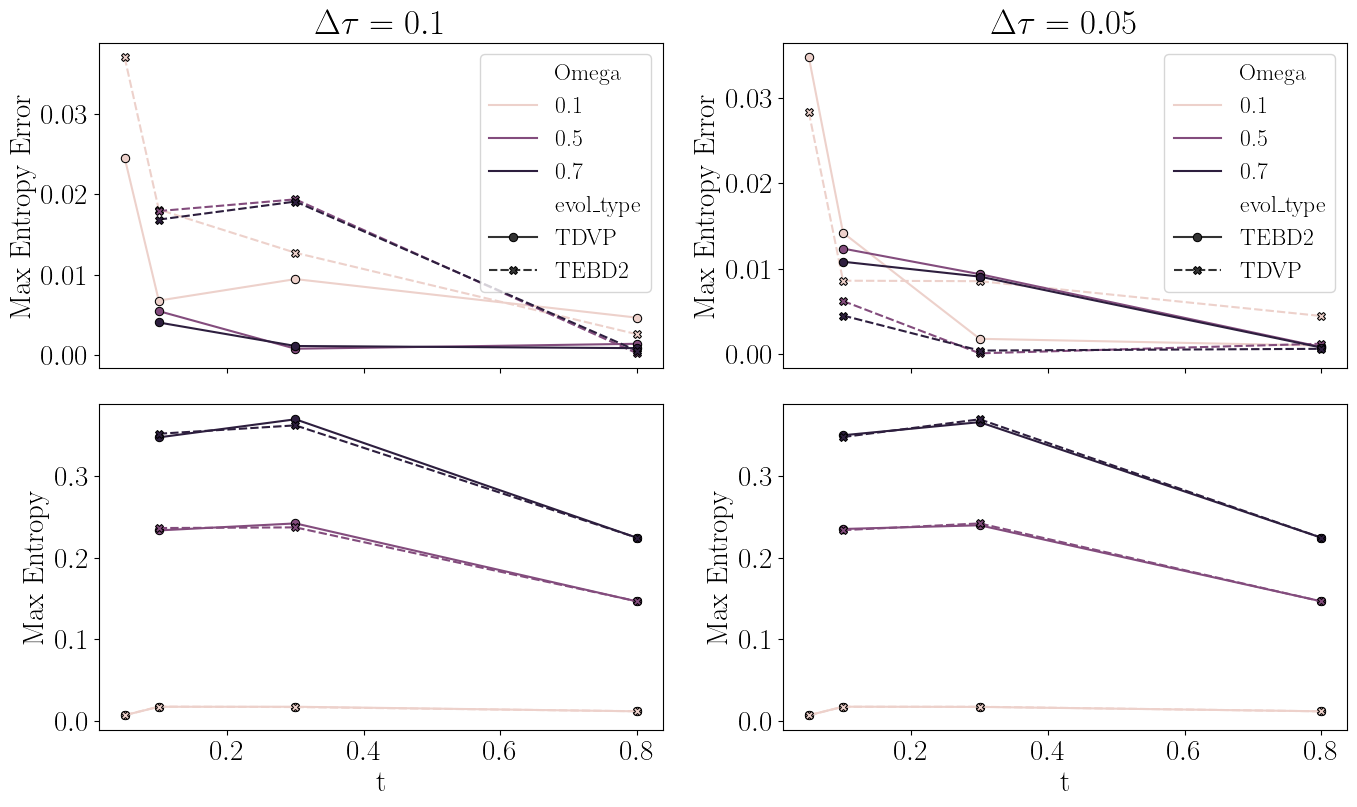

In [825]:
print(error_df.columns)

fig, ax = plt.subplots(2,2, figsize=(2*bwidth,1.7*bheight), sharex=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy_abserr", hue="Omega", style="evol_type",ax=ax[0,0],
             markers=True,legend=True, markeredgecolor="black")

sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy", hue="Omega", style="evol_type",ax=ax[1,0],
             markers=True,legend=False,markeredgecolor="black")

cond_ = (error_df["time_step"]==0.05) & (error_df["Omega"]!=0.0) 
sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy_abserr", hue="Omega", style="evol_type",ax=ax[0,1],
             markers=True,legend=True, markeredgecolor="black")

sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy", hue="Omega", style="evol_type",ax=ax[1,1],
             markers=True,legend=False,markeredgecolor="black")

# sns.move_legend(ax[0,1], "upper left", bbox_to_anchor=(1, 1))
ax[0,0].set_title(r"$\Delta \tau=0.1$")
ax[0,1].set_title(r"$\Delta \tau=0.05$")
ax[0,0].set_ylabel(r"Max Entropy Error")
ax[0,1].set_ylabel(r"Max Entropy Error")

ax[1,0].set_ylabel(r"Max Entropy")
ax[1,1].set_ylabel(r"Max Entropy")
    
plt.tight_layout() 

plt.savefig(fig_route+"Entropy_error_L=21.pdf")

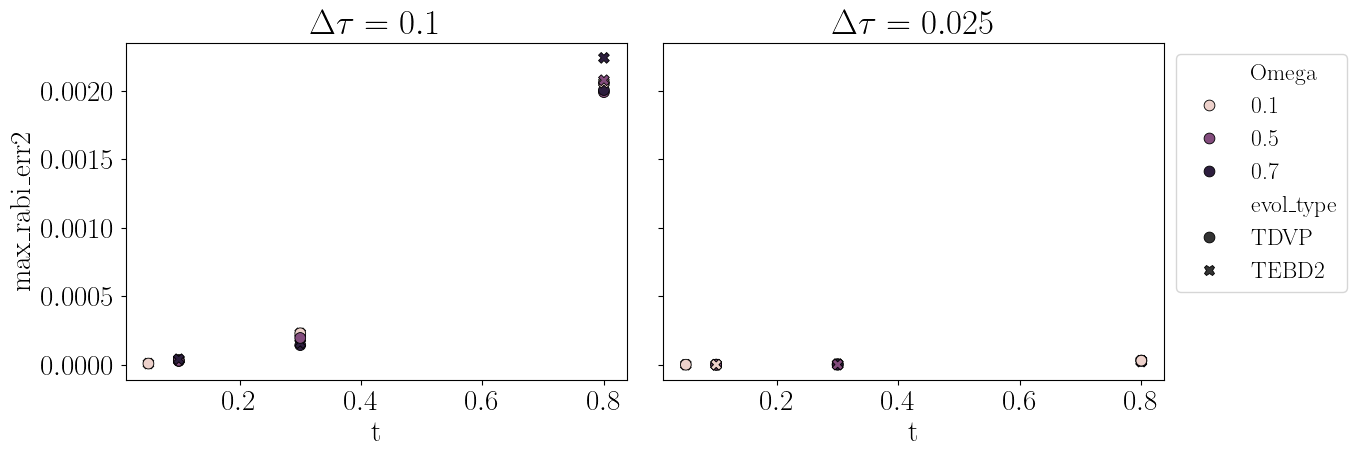

In [826]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_rabi_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[0], legend=False)

cond_ = (error_df["time_step"]==0.025) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_rabi_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[1])

sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title(r"$\Delta \tau=0.1$")
ax[1].set_title(r"$\Delta \tau=0.025$")
plt.tight_layout()

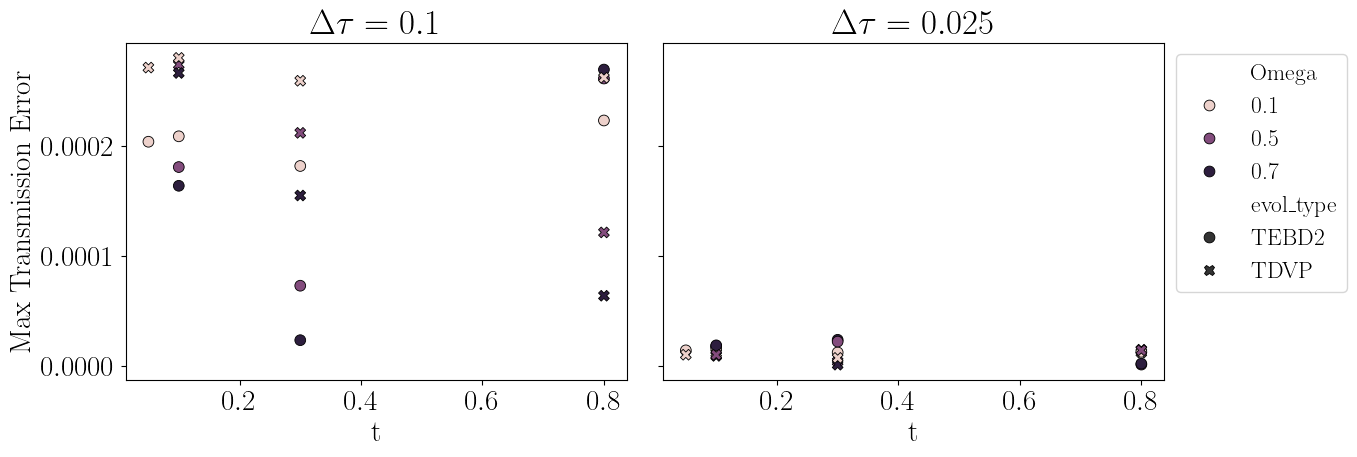

In [827]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_Transmision_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[0], legend=False)

cond_ = (error_df["time_step"]==0.05) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_Transmision_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[1])

sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title(r"$\Delta \tau=0.1$")
ax[1].set_title(r"$\Delta \tau=0.025$")
ax[0].set_ylabel(r"Max Transmission Error")

plt.tight_layout()
plt.savefig(fig_route+"transmission_error_L=21.pdf")

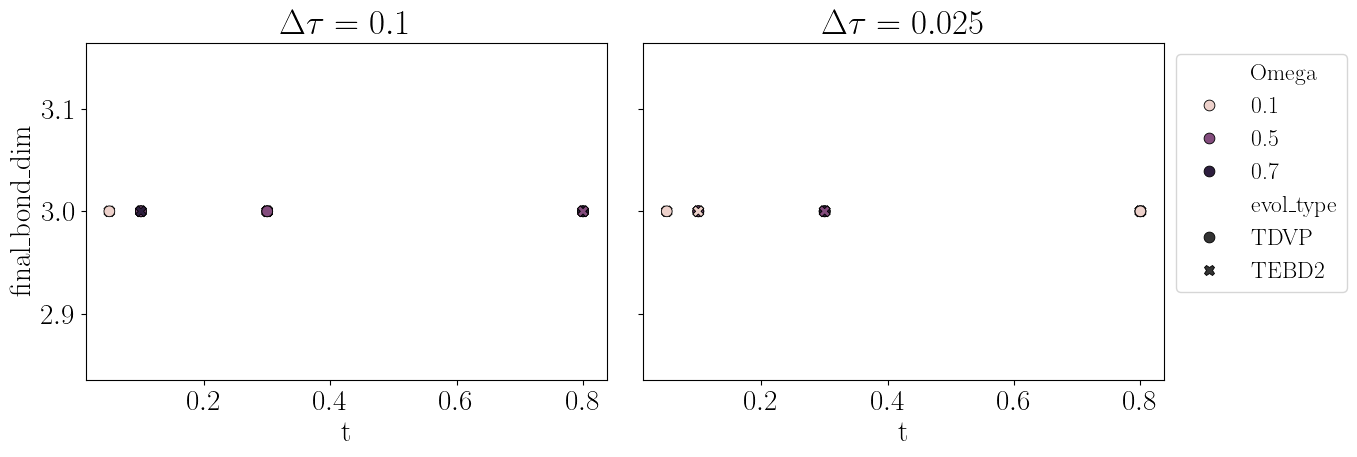

In [828]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="final_bond_dim", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[0], legend=False)

cond_ = (error_df["time_step"]==0.025) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="final_bond_dim", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[1])

sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title(r"$\Delta \tau=0.1$")
ax[1].set_title(r"$\Delta \tau=0.025$")
plt.tight_layout()


# Computation time and system size

In [883]:
TEBD_file_list = get_file_names_on(["TEBD"], "../../data/MPS/L_sweep/") # get all filenames for mps
TDVP_file_list = get_file_names_on(["TDVP"], "../../data/MPS/L_sweep/") 

TEBD_file_list, TDVP_file_list

(['TEBD2_L150_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex75_maxtau75.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L300_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex150_maxtau150.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L30_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex15_maxtau15.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L100_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex50_maxtau50.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L200_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex100_maxtau100.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L50_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex25_maxtau25.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L20_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex10_maxtau10.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5'],
 ['TDVP_L200_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex100_maxtau100.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TDVP_L150_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex75_maxtau75.0_tstep0.1_cuto

In [884]:
TEBD_comp_time_list = []
TEBD_size_list = []

TDVP_comp_time_list = []
TDVP_size_list = []
maxtime_list = [] # this is the same for both methods

# load tebd data
for MPS_file in TEBD_file_list:
    MPS_params, _, _, MPS_bond_dim, _, _  = load_MPS("../../data/MPS/L_sweep/", MPS_file) 
    TEBD_comp_time_list.append(MPS_params["computation_time"])
    TEBD_size_list.append(MPS_params["L"])
    maxtime_list.append(MPS_params["max_time"])

TEBD_comp_time_list = np.asarray(TEBD_comp_time_list)
TEBD_size_list = np.asarray(TEBD_size_list)
maxtime_list = np.asarray(maxtime_list)

# sort by system size and remove the compilation datapoint
sorted_index = np.argsort(TEBD_size_list)
TEBD_comp_time_list = TEBD_comp_time_list[sorted_index][1:]
TEBD_size_list = TEBD_size_list[sorted_index][1:]
maxtime_list = maxtime_list[sorted_index][1:]

# load tdvp data
for MPS_file in TDVP_file_list:
    MPS_params, _, _, MPS_bond_dim, _, _  = load_MPS("../../data/MPS/L_sweep/", MPS_file) 
    TDVP_comp_time_list.append(MPS_params["computation_time"])
    TDVP_size_list.append(MPS_params["L"])

TDVP_comp_time_list = np.asarray(TDVP_comp_time_list)
TDVP_size_list = np.asarray(TDVP_size_list)

# sort by system size and remove the compilation datapoint
sorted_index = np.argsort(TDVP_size_list)
TDVP_comp_time_list = TDVP_comp_time_list[sorted_index][1:]
TDVP_size_list = TDVP_size_list[sorted_index][1:]


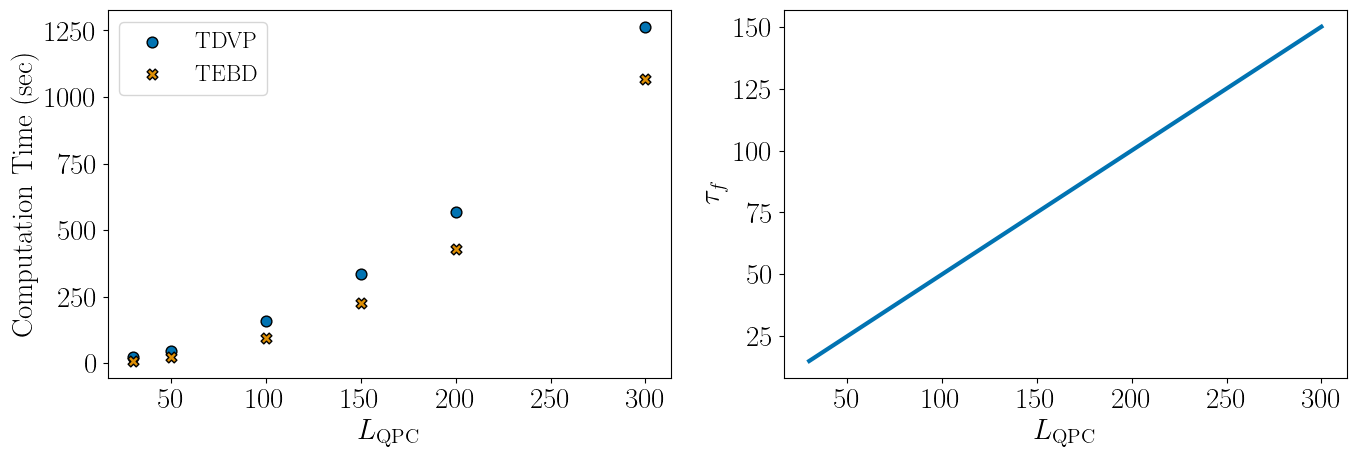

In [885]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

ax[0].scatter(TDVP_size_list, TDVP_comp_time_list, s=60, edgecolor="black", label="TDVP")
ax[0].scatter(TEBD_size_list, TEBD_comp_time_list, s=60, edgecolor="black" , label= "TEBD",marker="X")

ax[0].set_xlabel(r"$L_{\rm{QPC}}$")
ax[0].set_ylabel(r"Computation Time (sec)")
ax[0].legend()

ax[1].plot(TEBD_size_list, maxtime_list, linewidth=3)
ax[1].set_xlabel(r"$L_{\rm{QPC}}$")
ax[1].set_ylabel(r"$\tau_f$")

plt.tight_layout()

plt.savefig(fig_route+"computation_time_vs_size.pdf")

In [873]:
1250/60

20.833333333333332

## Look at single cases

In [886]:
L_ = 100
Om_ = 0.1
B_ = 50
t_ = 0.05
cutoff_ = -20
X0 = 20
step_ = 0.1
spread = 6.0

file_list = get_file_names_on(["TEBD2","L{}_".format(L_),"om{}_".format(Om_),
                              "bindex{}_".format(B_), "Del{}_".format(spread),
                              "xo{}_".format(X0), "tstep{}_".format(step_),
                              "cutoff{}_".format(cutoff_), "t{}_".format(t_) ], "../../data/MPS/L=100/")
print(file_list)
TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS("../../data/MPS/L=100/", file_list[0]) 

file_list = get_file_names_on(["TDVP","L{}_".format(L_),"om{}_".format(Om_),
                              "bindex{}_".format(B_), "Del{}_".format(spread),
                              "xo{}_".format(X0), "tstep{}_".format(step_),
                              "cutoff{}_".format(cutoff_),"t{}_".format(t_) ], "../../data/MPS/L=100/")
print(file_list)
TDVP_params, TDVP_times, TDVP_occ, TDVP_bond_dim, TDVP_entropies, TDVP_qubit_rho  = load_MPS("../../data/MPS/L=100/", file_list[0])


['TEBD2_L100_J1.0_t0.05_om0.1_Del6.0_xo20_k1.571_bindex50_maxtau50.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5']
['TDVP_L100_J1.0_t0.05_om0.1_Del6.0_xo20_k1.571_bindex50_maxtau50.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5']


In [887]:
TEBD_bindex = TEBD_params["bond_index"] # because of Julia indexing
TEBD_R = np.sum(TEBD_occ[:,:TEBD_bindex-1],axis=1)
TEBD_T = np.sum(TEBD_occ[:,TEBD_bindex+1:-2],axis=1)
TEBD_Bond = np.sum(TEBD_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)

TDVP_R = np.sum(TDVP_occ[:,:TEBD_bindex-1],axis=1)
TDVP_T = np.sum(TDVP_occ[:,TEBD_bindex+1:-2],axis=1)
TDVP_Bond = np.sum(TDVP_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)


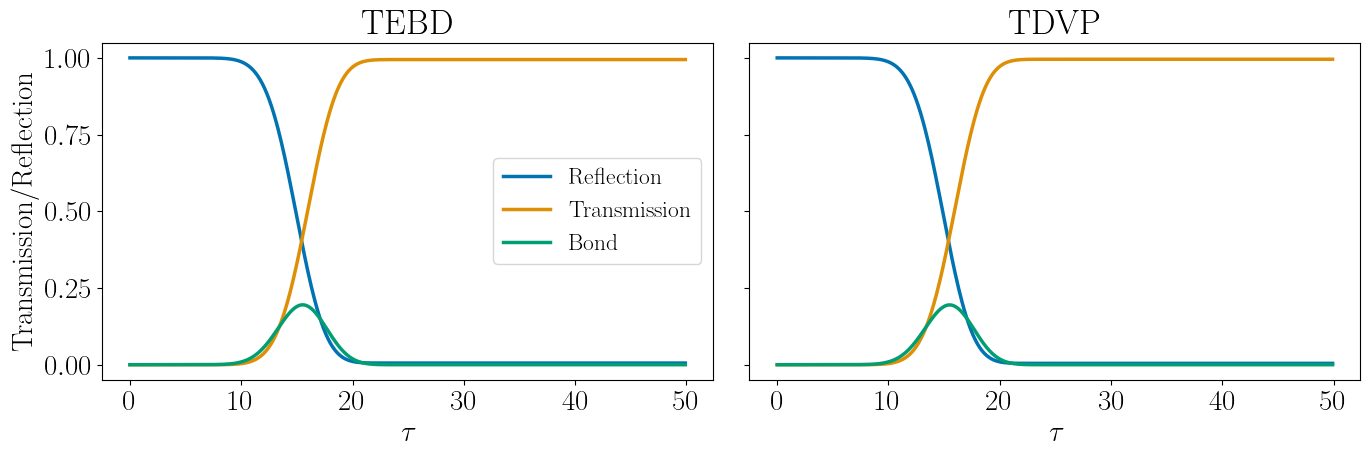

In [888]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

ax[0].plot(TEBD_times, TEBD_R, linewidth=2.5, label="Reflection")
ax[0].plot(TEBD_times, TEBD_T, linewidth=2.5, label="Transmission")
ax[0].plot(TEBD_times, TEBD_Bond, linewidth=2.5, label="Bond")
ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel(r"Transmission/Reflection")
ax[0].set_title("TEBD")
ax[0].legend()

ax[1].plot(TDVP_times, TDVP_R, linewidth=2.5)
ax[1].plot(TDVP_times, TDVP_T, linewidth=2.5)
ax[1].plot(TDVP_times, TDVP_Bond, linewidth=2.5)
ax[1].set_xlabel(r"$\tau$")
ax[1].set_title("TDVP")

plt.tight_layout()

# plt.savefig(fig_route+"transmission_reflection_L={}_spread={}_X0={}.pdf".format(L_, X0, spread))

0.005563063295426074
TEBD final bond dimension: 3
TEBD max bond dimension: 54 found at 0
TDVP final bond dimension: 3
TDVP max bond dimension: 54 found at 0


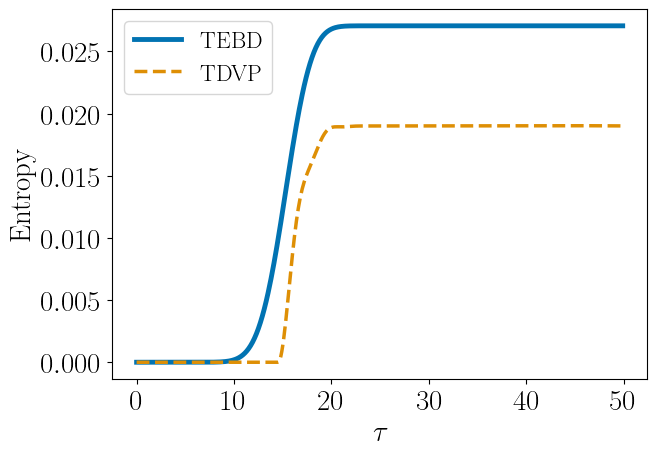

In [877]:
fig, ax = plt.subplots(1,1, figsize=(bwidth,bheight))

plt.plot(TEBD_times, TEBD_entropies/np.log(2), linewidth=3.5, label="TEBD")
plt.plot(TDVP_times, TDVP_entropies/np.log(2),linewidth=2.5,label="TDVP", linestyle="dashed")

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"Entropy")
ax.legend()

plt.tight_layout()

print(np.max(TEBD_entropies)-np.max(TDVP_entropies))

print("TEBD final bond dimension:", TEBD_bond_dim[-1])
print("TEBD max bond dimension:", np.max(TEBD_bond_dim), "found at",  np.argmax(TEBD_bond_dim))

print("TDVP final bond dimension:", TDVP_bond_dim[-1])
print("TDVP max bond dimension:", np.max(TDVP_bond_dim), "found at",  np.argmax(TDVP_bond_dim))

# plt.savefig(fig_route+"entropy_production_L={}_spread={}_X0={}.pdf".format(L_, X0, spread))

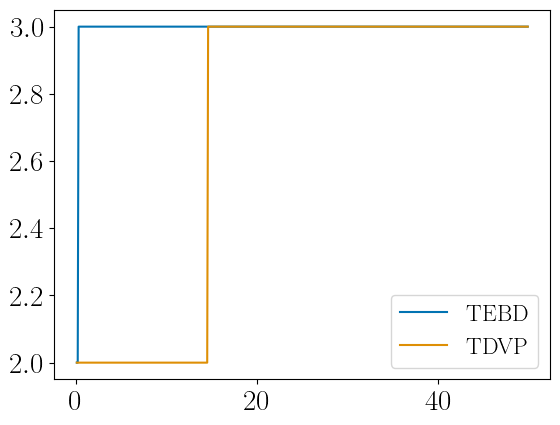

In [878]:
plt.plot(TEBD_times[1:], TEBD_bond_dim[1:], label="TEBD")
plt.plot(TDVP_times[1:], TDVP_bond_dim[1:], label="TDVP")

plt.legend()

**Spread of the wavepacket**

TEBD FWHM:  9.997405666293213
TDVP FWHM:  10.00100582318782


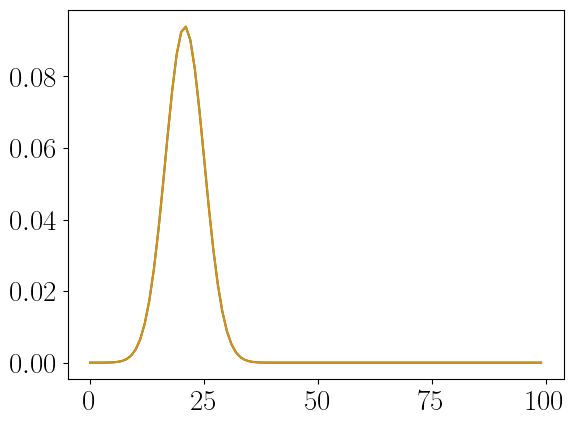

In [879]:
tindex_ = 9
FWHM = get_FWHM(np.arange(0,len(TEBD_occ[time_index,:L_])) , TEBD_occ[time_index,:L_], tindex_)
print("TEBD FWHM: ", FWHM)

FWHM = get_FWHM(np.arange(0,len(TDVP_occ[time_index,:L_])) , TDVP_occ[time_index,:L_], tindex_)
print("TDVP FWHM: ", FWHM)
plt.plot(TEBD_occ[tindex_,:L_])
plt.plot(TDVP_occ[tindex_,:L_])


**TEBD trajectory**

In [880]:
heat_matrix = TEBD_occ.T
np.shape(heat_matrix)
vg = 2*TEBD_params["J"]*np.sin(TEBD_params["k0"])
xvg = TEBD_params["x0"] + TEBD_times *vg
tau_free = (L_-TEBD_params["x0"])/vg
tau_free


40.0

estimated time to hit the far wall without coupling:  40.0


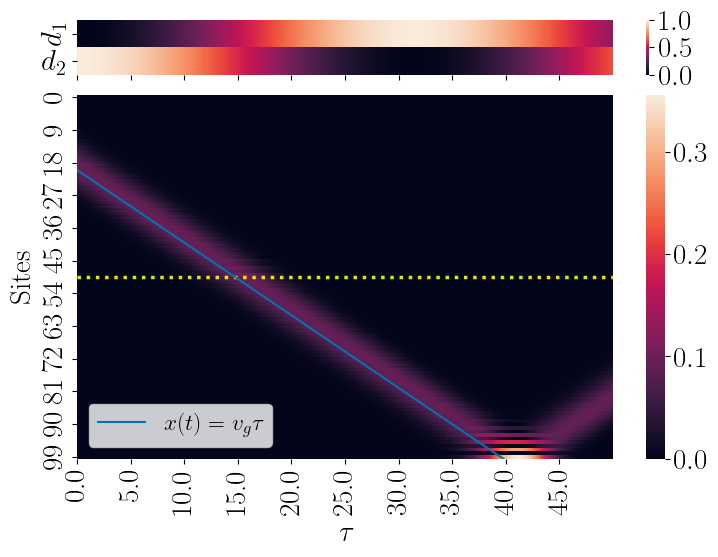

In [881]:
print("estimated time to hit the far wall without coupling: ", tau_free)

fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

sns.heatmap(heat_matrix[L_:,:],ax=ax[0])
sns.heatmap(heat_matrix[:L_,:],ax=ax[1])

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel("Sites")

ax[1].axhline(TEBD_params["bond_index"], alpha=0.9,linestyle='dotted' ,c="yellow",linewidth=2.5)
ax[1].plot(xvg+0.5, label= r"$x(t)=v_g \tau$")

ax[0].set_yticks([0.5,1.5], [r"$d_1$",r"$d_2$"])
# time ticks
tick_posx = np.arange(0,len(TEBD_times),50)
xtick_label = np.around(tick_posx*(TEBD_params["time_step"]),decimals=1)
ax[1].set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
# reduce vertical
plt.tight_layout(h_pad=0.01)

# plt.savefig(fig_route+"TEBD_trajectory_L={}_spread={}_X0={}.png".format(L_, X0, spread), dpi = 200)

**TDVP trajectory**

In [882]:
heat_matrix = TDVP_occ.T
np.shape(heat_matrix)
vg = 2*TDVP_params["J"]*np.sin(TDVP_params["k0"])
xvg = TDVP_params["x0"] + TDVP_times *vg
tau_free = (L_-TDVP_params["x0"])/vg
tau_free

40.0

estimated time to hit the far wall without coupling:  40.0


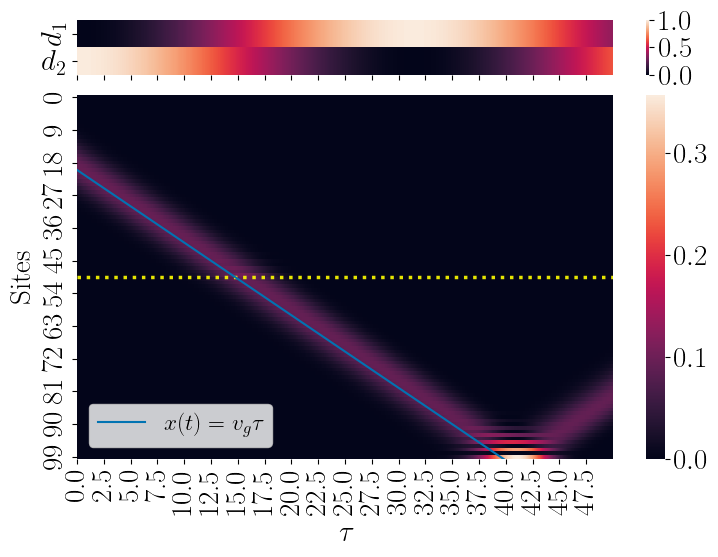

In [772]:
print("estimated time to hit the far wall without coupling: ", tau_free)

fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

sns.heatmap(heat_matrix[L_:,:],ax=ax[0])
sns.heatmap(heat_matrix[:L_,:],ax=ax[1])

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel("Sites")

ax[1].axhline(TEBD_params["bond_index"], alpha=0.9,linestyle='dotted' ,c="yellow",linewidth=2.5)
ax[1].plot(xvg+0.5, label= r"$x(t)=v_g \tau$")

ax[0].set_yticks([0.5,1.5], [r"$d_1$",r"$d_2$"])
# time ticks
tick_posx = np.arange(0,len(TEBD_times),50)
xtick_label = np.around(tick_posx*(TEBD_params["time_step"]),decimals=1)
ax[1].set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
# reduce vertical
plt.tight_layout(h_pad=0.01)
# plt.savefig(fig_route+"TDVP_trajectory_L={}_spread={}_X0={}.png".format(L_, X0, spread), dpi = 200)

# Single cases vs Exact diag

In [779]:
J=1
om_ = 0.1
t_ = 0.05
time_step_ = 0.1
cutoff_exp = -20


In [780]:
# names for exact diag
file_list = get_file_names_on(["bw2.0","om{}_".format(om_),"dd0fixed", "k1.5708", "t{}".format(t_)], data_route)
file_name = file_list[0]
file_list

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.05_om0.1_dd0fixed.hdf5']

In [781]:
# names for TEBD
file_list = get_file_names_on(["TEBD","Del2.0", "om{}".format(om_), "free", 
                               "k1.571", "t{}".format(t_),"theta3.142","phi-1.571", 
                               "tstep{}".format(time_step_), "cutoff{}".format(cutoff_exp)], MPS_route)
TEBD_file = file_list[0]

#names for TDVP 
file_list = get_file_names_on(["TDVP","Del2.0", "om{}".format(om_), "free", 
                               "k1.571", "t{}".format(t_),"theta3.142","phi-1.571",
                               "tstep{}".format(time_step_)], MPS_route)
TDVP_file = file_list[0]

print(TEBD_file)
print(TDVP_file)


TEBD2_L21_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex8_maxtau18_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5
TDVP_L21_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex8_maxtau18_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5


In [782]:
# load exact diagonalization
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,file_name)

# load TEBd
TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(MPS_route, TEBD_file)  

# load TDVP
TDVP_params, TDVP_times, TDVP_occ, TDVP_bond_dim, TDVP_entropies, TDVP_qubit_rho  = load_MPS(MPS_route, TDVP_file) 
TEBD_params,TDVP_params


({'Omega': 0.1,
  'x0': 1,
  'computation_time': 7.886611875,
  'L': 21,
  'cutoff': 1e-20,
  't': 0.05,
  'bond_index': 8,
  'max_time': 18,
  'k0': 1.5707963267948966,
  'qinit': 'free',
  'spread': 2.0,
  'qubit_theta': 3.141592653589793,
  'J': 1.0,
  'evol_type': 'TEBD2',
  'time_step': 0.1,
  'type': 'TEBD2',
  'qubit_phi': -1.5707963267948966},
 {'Omega': 0.1,
  'x0': 1,
  'computation_time': 19.003411125,
  'L': 21,
  'cutoff': 1e-20,
  't': 0.05,
  'bond_index': 8,
  'max_time': 18,
  'k0': 1.5707963267948966,
  'qinit': 'free',
  'spread': 2.0,
  'qubit_theta': 3.141592653589793,
  'J': 1.0,
  'evol_type': 'TDVP',
  'time_step': 0.1,
  'type': 'TDVP',
  'qubit_phi': -1.5707963267948966})

## Rabi Oscillations

In [783]:
TEBD_d1 = TEBD_occ[:,-2]
TEBD_d2 = TEBD_occ[:,-1]

TDVP_d1 = TDVP_occ[:,-2]
TDVP_d2 = TDVP_occ[:,-1]

d1_interpol = interpolate_short_array(TEBD_d1,n_d1)
tdvp_d1_interpol = interpolate_short_array(TDVP_d1,n_d1)

Err2 = (d1_interpol - n_d1)**2
Err2_tdvp = (tdvp_d1_interpol- n_d1)**2


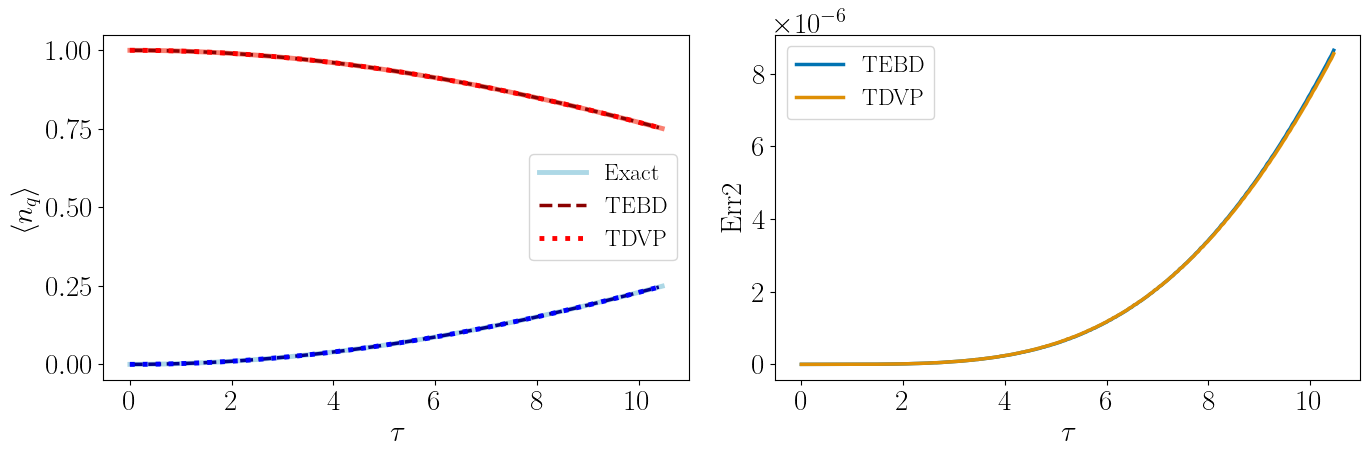

In [784]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

ax[0].plot(times, n_d1, c="lightblue", linewidth=3.5, label="Exact")
ax[0].plot(times, n_d2, c="salmon",linewidth=3.5)
ax[0].plot(TEBD_times, TEBD_d1, linestyle="dashed",linewidth=2.5, c="darkblue")
ax[0].plot(TEBD_times, TEBD_d2, linestyle="dashed",linewidth=2.5, c="darkred", label="TEBD")
ax[0].plot(TDVP_times, TDVP_d1, linestyle="dotted",linewidth=3.5, c="blue")
ax[0].plot(TDVP_times, TDVP_d2, linestyle="dotted",linewidth=3.5, c="red", label="TDVP")

ax[1].plot(times, Err2,linewidth=2.5, label="TEBD")
ax[1].plot(times, Err2_tdvp,linewidth=2.5,label="TDVP")


ax[0].set_ylabel(r"$\langle n_q \rangle$")
ax[0].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"Err2")
ax[1].set_xlabel(r"$\tau$")


ax[0].legend()
ax[1].legend()

plt.tight_layout()

plt.savefig(fig_route+"rabi_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


## Transmission/Reflection coefficients

In [785]:
TEBD_bindex = TEBD_params["bond_index"] # because of Julia indexing
TEBD_R = np.sum(TEBD_occ[:,:TEBD_bindex-1],axis=1)
TEBD_T = np.sum(TEBD_occ[:,TEBD_bindex+1:-2],axis=1)
TEBD_Bond = np.sum(TEBD_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)

TDVP_R = np.sum(TDVP_occ[:,:TEBD_bindex-1],axis=1)
TDVP_T = np.sum(TDVP_occ[:,TEBD_bindex+1:-2],axis=1)

# calculate the errors
TEBD_R_interpol = interpolate_short_array(TEBD_R,n_left)
Err2_R = (TEBD_R_interpol - n_left)**2

TEBD_T_interpol = interpolate_short_array(TEBD_T,n_right)
Err2_T = (TEBD_T_interpol - n_right)**2

# interpolate for first and last site
TEBD_first_interpol = interpolate_short_array(TEBD_occ[:,0],traject[0,:])
Err_2_first =  (TEBD_first_interpol - traject[0,:])**2


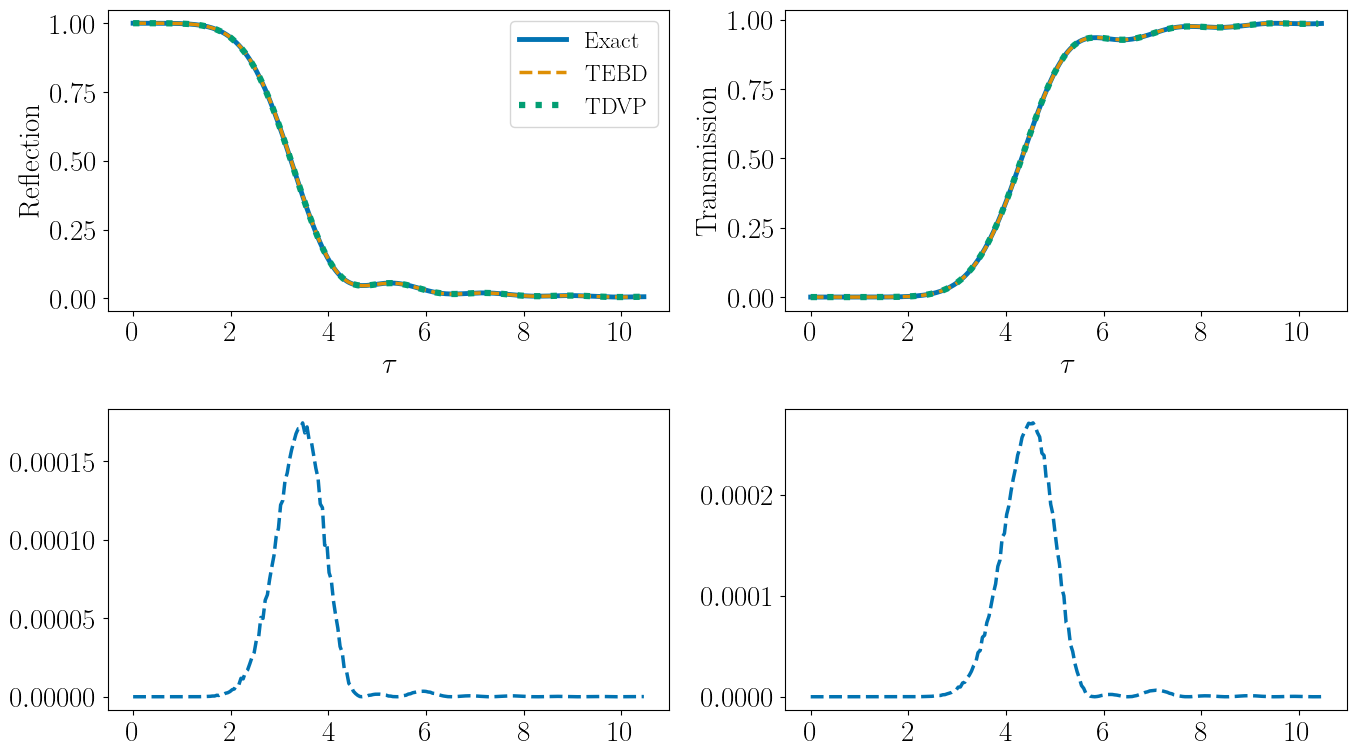

In [786]:
fig, ax = plt.subplots(2,2 , figsize=(2*bwidth,1.6*bheight))

ax[0,0].plot(times, n_left, linewidth=3.5, label="Exact")
ax[0,0].plot(TEBD_times, TEBD_R, linewidth=2.5, label="TEBD", linestyle="dashed")
ax[0,0].plot(TDVP_times, TDVP_R, linewidth=4.5, label="TDVP", linestyle="dotted")


ax[0,1].plot(times, n_right, linewidth=3.5)
ax[0,1].plot(TEBD_times, TEBD_T, linewidth=2.5, linestyle="dashed")
ax[0,1].plot(TDVP_times, TDVP_T, linewidth=4.5, linestyle="dotted")

ax[1,0].plot(times, Err2_R, linewidth=2.5, linestyle="dashed")
ax[1,1].plot(times, Err2_T, linewidth=2.5, linestyle="dashed")


ax[0,0].set_ylabel(r"Reflection ")
ax[0,0].set_xlabel(r"$\tau$")
ax[0,1].set_ylabel(r"Transmission ")
ax[0,1].set_xlabel(r"$\tau$")
ax[0,0].legend()

plt.tight_layout()

plt.savefig(fig_route+"QPC_coeffs_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


## Entropy

In [787]:
# this time is the exact entropy the one we sample less
Entropy_interpol = interpolate_short_array(VN_entropy, TEBD_entropies)
Entropy_Err2 = (TEBD_entropies- Entropy_interpol)**2

Entropy_interpol = interpolate_short_array(VN_entropy, TDVP_entropies)
TDVPEntropy_Err2 = (TDVP_entropies- Entropy_interpol)**2



In [788]:
np.abs(max(VN_entropy) - max(TEBD_entropies))/max(VN_entropy)

0.03710500799542481

In [789]:
np.abs(max(VN_entropy) - max(TDVP_entropies))/max(VN_entropy)

0.02458746931082249

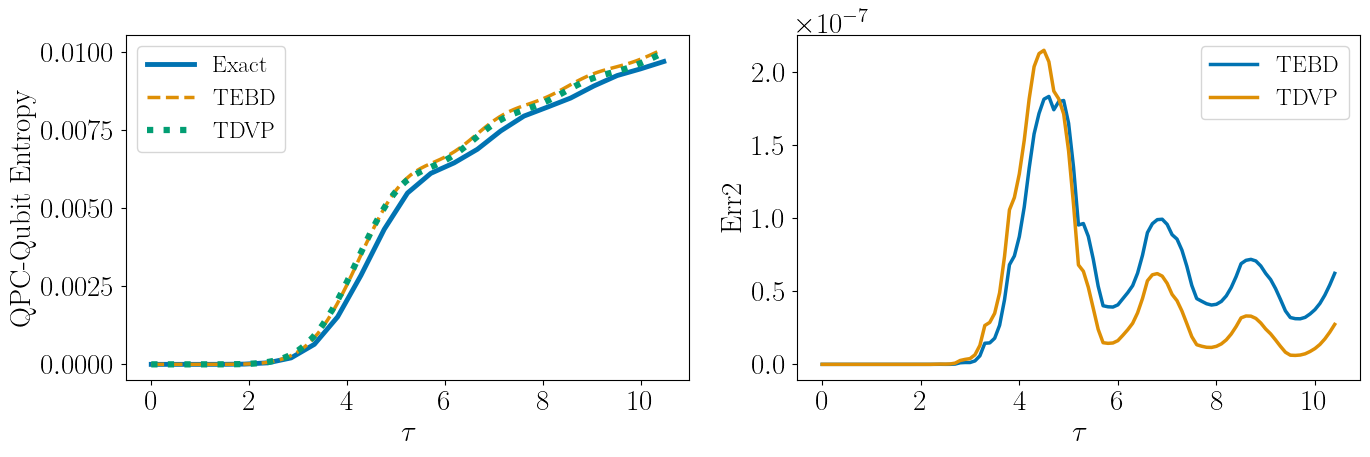

In [790]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

# since we dont calculate the entropy at each time
times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))

# divide by singlet entropy
ax[0].plot(times_coarse, VN_entropy/np.log(2), linewidth=3.5,label="Exact")
ax[0].plot(TEBD_times ,TEBD_entropies/np.log(2),linewidth=2.5, linestyle="dashed", label="TEBD")
ax[0].plot(TDVP_times ,TDVP_entropies/np.log(2),linewidth=4.5, linestyle="dotted", label="TDVP")


ax[0].set_ylabel(r"QPC-Qubit Entropy")
ax[0].set_xlabel(r"$\tau$")
ax[0].legend()

ax[1].plot(TEBD_times, Entropy_Err2, linewidth=2.5,label="TEBD")
ax[1].plot(TDVP_times, TDVPEntropy_Err2, linewidth=2.5,label="TDVP")

ax[1].set_ylabel(r"Err2")
ax[1].set_xlabel(r"$\tau$")
ax[1].legend()


plt.tight_layout()

plt.savefig(fig_route+"entropy_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


## Bloch Sphere

In [208]:
theta_list, phi_list = get_bloch_angles(TEBD_qubit_rho)
    

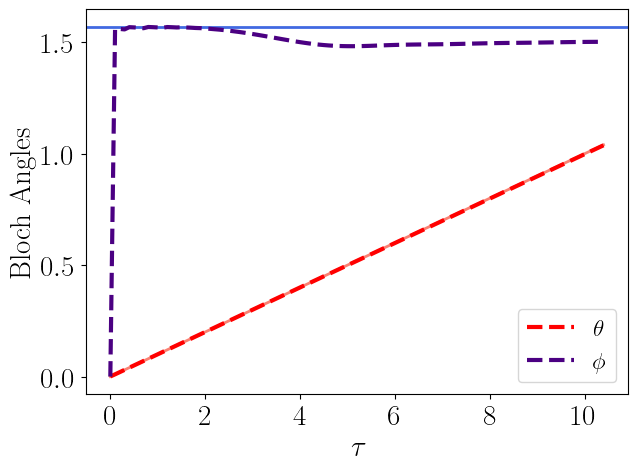

In [209]:
theta_free = 2*TEBD_params["t"]*TEBD_times

fig, ax = plt.subplots(1,1, figsize=(bwidth,bheight))

# free case
ax.axhline(np.abs(TEBD_params["qubit_phi"]), c="royalblue",linewidth=2)
ax.plot(TEBD_times, theta_free, c="salmon",linewidth=2) 

# interacting case
ax.plot(TEBD_times, theta_list, linestyle="dashed", linewidth=3, c="red", label=r"$\theta$")
ax.plot(TEBD_times, phi_list,linestyle="dashed",linewidth=3, c="indigo",label=r"$\phi$")

plt.xlabel(r"$\tau$")
plt.ylabel(r"Bloch Angles")
plt.legend()